In [1]:
import sys
import random

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Compose, CenterCrop, Resize, Normalize
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from nuy_v2_loader import NYUV2Dataset
from stepper import Stepper, MultiTermLossStepper
from summary_writer import SummaryWriter, WandBSummaryWritter
from loss import nyuv2_loss_fn, sil_loss, grad_l1_loss, dssim, nyuv2_multiterm_loss_fn, nyuv2_multiterm_loss_fn_vit, ZScoreEWMALoss, ComposeEWMALoss, CoVWeightingLoss
from models.res_refinet import Resnet101RefineNet
from models.compose_net import ComposeNet
from multiterm_optim import MultiTermAdam

In [2]:
%run -i 'constants.py'

In [3]:
BATCH_SIZE = 16
MAX_DATA_LENGHT = None

EPOCHS = 10
LR = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False    
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# if not os.path.exists('datasets/diode.tar.gz'):
#     subprocess.run(
#         ['curl', '-L', '-o', 'datasets/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
#         check=True
#     )

In [6]:
NYU_V2_IMG_DIMENSION = (448, 608)

transforms = Compose([
  ToTensor(), CenterCrop(NYU_V2_IMG_DIMENSION), Resize(size=INPUT_SIZE),
])
rgb_t = Compose([
  transforms,
  Normalize(mean=RGB.mean, std=RGB.std),
  v2.RandomChannelPermutation(),
])

train_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'train', download=True, max_lenght=MAX_DATA_LENGHT)
test_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'test', download=True, max_lenght=MAX_DATA_LENGHT)

Failed to load tar file
Finished loading dataset
Failed to load tar file
Finished loading dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


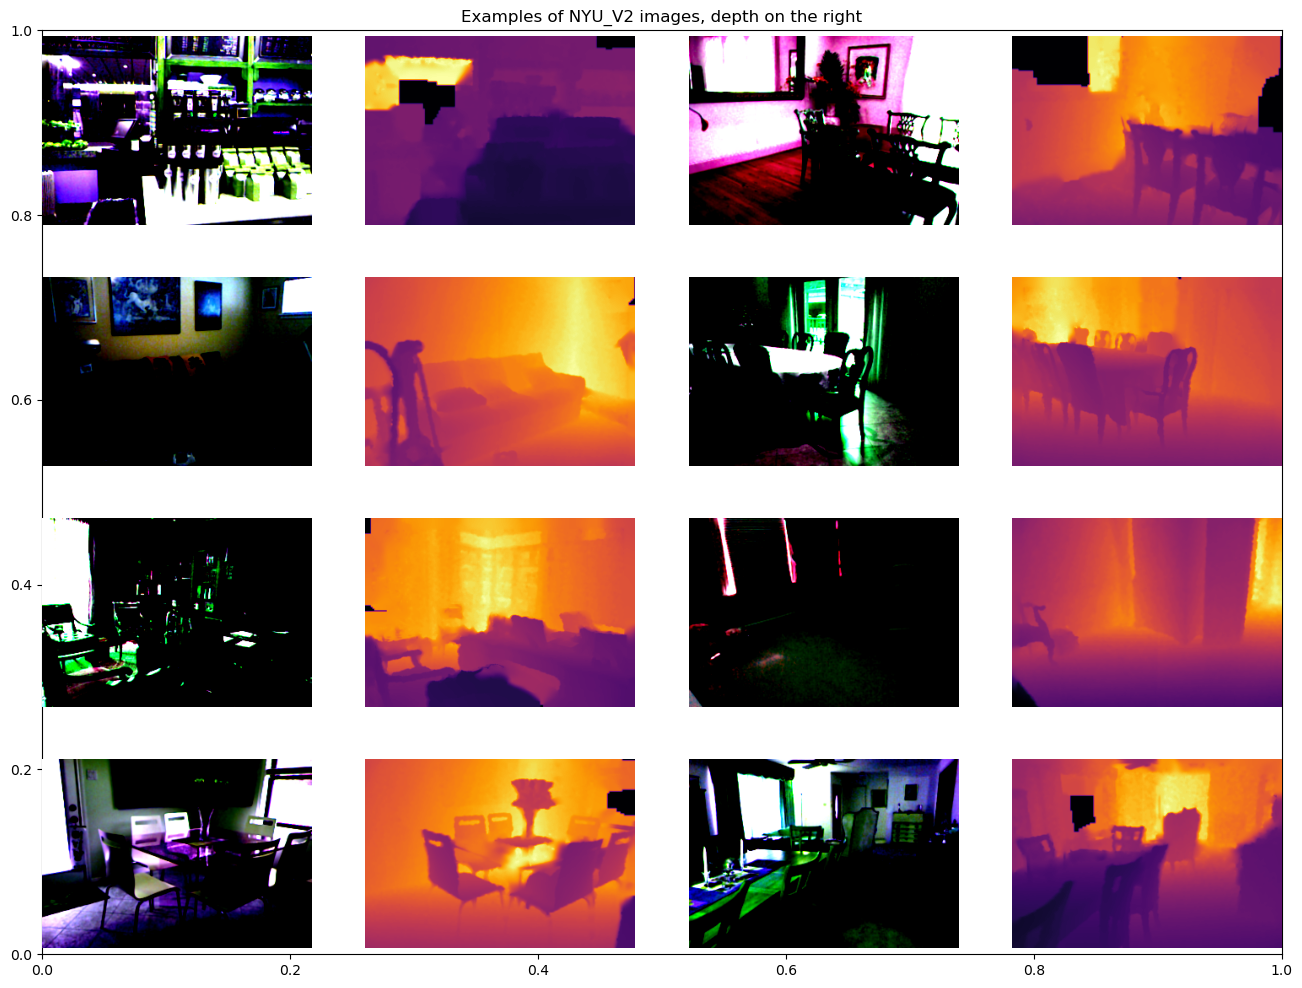

In [7]:
random_pick = np.random.randint(0, 45000, 8)

plt.figure(figsize=(16, 12))
plt.title("Examples of NYU_V2 images, depth on the right")
for i, img in enumerate(random_pick):
  ax = plt.subplot(4, 4, i * 2 +1)
  rgb, depth = train_dataset[img]
  ax.imshow(rgb.permute((1, 2, 0)))
  ax.set_axis_off()
  
  ax = plt.subplot(4, 4, i * 2 + 2)
  ax.imshow(depth[0], cmap='inferno')
  ax.set_axis_off()

# As we can see data isn't perfect, sensor weren't able to capture highly illuminated objects, mirrors and etc

## Baseline

In [8]:
# summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)
summary_writer = None

generator = torch.Generator()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = ComposeNet(inputsize=INPUT_SIZE, decoder_channels=256, vit_channels_in=64, classes=128)
optim = AdamW(model.parameters(), lr=LR)
# lr_scheduler = ReduceLROnPlateau(optim, factor=0.1, patience=2, threshold=2e-3)
lr_scheduler = OneCycleLR(
  optim, 
  LR, 
  epochs=EPOCHS, 
  steps_per_epoch=len(train_loader),
  cycle_momentum=True,
  div_factor=25,
  final_div_factor=1e3
)


loss_fn = ZScoreEWMALoss(loss_fn=nyuv2_multiterm_loss_fn, n_functions=3, device=device).train()
stepper = Stepper(model, optim=optim, loss_fn=loss_fn, summary_writter=summary_writer)
stepper.set_loaders(train_loader, val_loader)
stepper.set_lr_schedulers(lr_scheduler, over_batch=True)
stepper.to(device)

summary_writer.register(
  project='pure_depth',
  config={
    'architecture': repr(model),
    'optim': 'AdamW',
    'device': device,
    'batch_size': BATCH_SIZE,
    'loss_fn': stepper.loss_fn.__doc__,
    'scale_invariance_alpha': SCALE_INVARIANCE_ALPHA,
    'epochs': EPOCHS
  }
)

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[('',
  
      ComposeNet(
        inputsize=(224, 320),
        min_max_values=(0, 10),
        decoder_channels=256,
        vit_channels_in=64,
        classes=128
      )
      ),
 ('backbone',
  DensenetBackbone(
    (model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [9]:
# summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# resnet101_refinet = Resnet101RefineNet()
# optim = MultiTermAdam(resnet101_refinet.parameters(), lr=1e-4, betas=(0.8, 0.98, 0.7))
# stepper = MultiTermLossStepper(resnet101_refinet, optim=optim, loss_fn=nyuv2_multiterm_loss_fn, summary_writter=summary_writer)
# stepper.set_loaders(train_loader, val_loader)
# stepper.to(device)

# summary_writer.register(
#   project='pure_depth',
#   config={
#     'architecture': 'Resnet101_Refinet',
#     'optim': 'MultiTermAdam',
#     'device': device,
#     'batch_size': BATCH_SIZE,
#     'loss_fn': stepper.loss_fn.__doc__
#   }
# )

In [10]:
# torch.autograd.set_detect_anomaly(True)
stepper.train(n_epochs=EPOCHS)
stepper.save_checkpoint(file_name=f'artifacts/{summary_writer.name}')

validation step: 100%|██████████| 41/41 [00:28<00:00,  1.45batch/s, loss=0.168]


In [ ]:
# stepper.load_checkpoint('artifacts/jem-hadar-data-208')

In [ ]:
# Just sanity check
x, y = test_dataset[621]
stepper.model.eval()
pred = stepper.model(x.unsqueeze(0).to(device))

vmax = y.max()
plt.figure(figsize=(8, 6))
ax0 = plt.subplot(1, 2, 1)
show = ax0.imshow(
  np.transpose(pred[0].detach().cpu().numpy(), (1, 2, 0)),
  cmap='inferno',
  vmin=0
)
plt.colorbar(show, ax=ax0)
ax1 = plt.subplot(1, 2, 2)
show = ax1.imshow(
  np.transpose(y.detach().numpy(), (1, 2, 0)), 
  cmap='inferno', 
  vmin=0
)
plt.colorbar(show, ax=ax1)

In [ ]:
summary_writer.track_object({"train_eval": stepper.gather_metrics(False)})

In [ ]:
summary_writer.finalize()